In [125]:
# Importing all the necessary libraries
from unet_model import UNet_Model

from keras.utils import normalize
from keras.utils import to_categorical
from keras.metrics import MeanIoU
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [126]:
# Defining the size of the image and the number of classes
SIZE_X = 64
SIZE_Y = 64
n_classes = 10

(2115, 64, 64, 1)


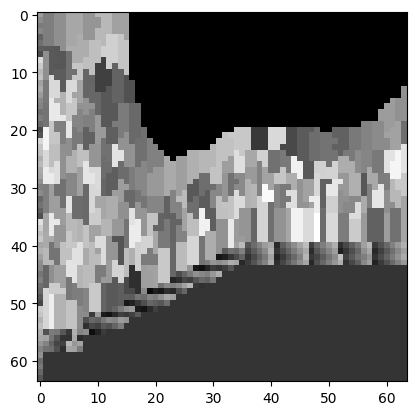

In [127]:
# Loading the input images
train_images = []

for directory_path in glob.glob("data/images/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        train_images.append(img)

train_images = np.array(train_images)
train_images = train_images.reshape(train_images.shape[0], SIZE_X, SIZE_Y, 1)

plt.imshow(train_images[0], cmap="gray")
print(train_images.shape)

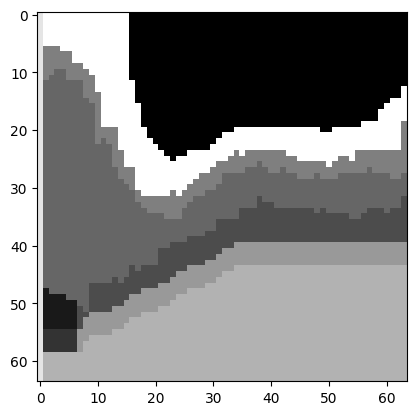

In [128]:
# Loading the input masks
train_masks = []
for directory_path in glob.glob("data/masks/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        train_masks.append(mask)

train_masks = np.array(train_masks)

plt.imshow(train_masks[0], cmap="gray")

In [129]:
# Label encoding the pixel values of the masks
LabelEncoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = LabelEncoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [130]:
# Normalizing the images
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [131]:
# Splitting the dataset into training and testing
X1, X_test, y1, y_test = train_test_split(
    train_images, train_masks_input, test_size=0.10, random_state=0
)

# Splitting the training dataset into training and validation
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(
    X1, y1, test_size=0.20, random_state=0
)

print("Class valuues in the dataset are ... ", np.unique(y_train))

Class valuues in the dataset are ...  [0 1 2 3 4 5 6 7 8 9]


In [132]:
# One hot encoding the masks
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape(
    (y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)
)

# One hot encoding the masks
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape(
    (y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes)
)

In [133]:
# Computing the initial class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_masks_reshaped_encoded),
    y=train_masks_reshaped_encoded,
)
print("Class weights are... ", class_weights)

Class weights are...  [ 0.42213923 12.77791053 17.06666667  1.30560671  0.50920928  1.96274806
  1.79649123  0.4231405   6.4         0.84829055]


In [134]:
# Initializing the input image dimesnions
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [135]:
# Defining the model
def get_model(pre_layer):
    return UNet_Model(
        n_classes=10,
        pre_layer=pre_layer,
        IMG_HEIGHT=IMG_HEIGHT,
        IMG_WIDTH=IMG_WIDTH,
        IMG_CHANNELS=IMG_CHANNELS,
    )

In [136]:
# Compiling the model
model = get_model(False)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 64, 64,    │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 64, 64,    │          0 │ conv2d_76[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 64, 64,    │      2,320 │ dropout_36[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 32, 32,    │          0 │ conv2d_77[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 32, 32,    │      4,640 │ max_pooling2d_16… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 32, 32,    │          0 │ conv2d_78[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 32, 32,    │      9,248 │ dropout_37[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 16, 16,    │          0 │ conv2d_79[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 16, 16,    │          0 │ conv2d_80[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 16, 16,    │     36,928 │ dropout_38[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 8, 8, 64)  │          0 │ conv2d_81[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ max_pooling2d_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 8, 8, 128) │          0 │ conv2d_82[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 4, 4, 128) │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,940,970 (7.40 MB)

 Trainable params: 1,940,970 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
# Training the model and saving the weights
history = model.fit(
    X_train,
    y_train_cat,
    batch_size=16,
    epochs=50,
    verbose=1,
    validation_data=(X_test, y_test_cat),
    # class_weight=class_weights,
    shuffle=False,
)
model.save("new_unet_model.h5")

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 53s 556ms/step - accuracy: 0.8605 - loss: 0.3656 - val_accuracy: 0.8881 - val_loss: 0.2844
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 811ms/step - accuracy: 0.9284 - loss: 0.1799 - val_accuracy: 0.9339 - val_loss: 0.1598
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 777ms/step - accuracy: 0.9368 - loss: 0.1528 - val_accuracy: 0.9383 - val_loss: 0.1485
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9407 - loss: 0.1413 - val_accuracy: 0.9457 - val_loss: 0.1316
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9438 - loss: 0.1339 - val_accuracy: 0.9456 - val_loss: 0.1306
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 88s 924ms/step - accuracy: 0.9458 - loss: 0.1284 - val_accuracy: 0.9492 - val_loss: 0.1213
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 68s 705ms/step - accuracy: 0.9476 - loss: 0.1239 - val_accuracy: 0.9500 - val_loss: 0.1191
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 82s 855ms/step - accuracy: 0.9495 - loss: 0.1194 - val_accuracy: 

In [140]:
# Loading the model weights and evaluating the accuracy
model.load_weights("unet_model.h5")
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.9805 - loss: 0.0545
Accuracy is =  97.99585938453674 %


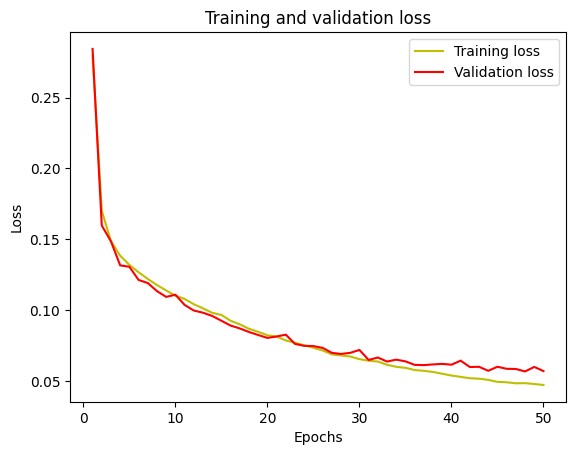

In [141]:
# Plotting the training and validation loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [142]:
# Loading the model weights
model.load_weights("unet_model.h5")

In [143]:
# Predicting the masks on the test images
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  


In [144]:
# Calculating the mean IoU
n_classes = 10
IoU_keras = MeanIoU(num_classes=n_classes)
IoU_keras.update_state(y_test[:, :, :, 0], y_pred_argmax)
print("Mean IoU =", IoU_keras.result().numpy())

Mean IoU = 0.948878


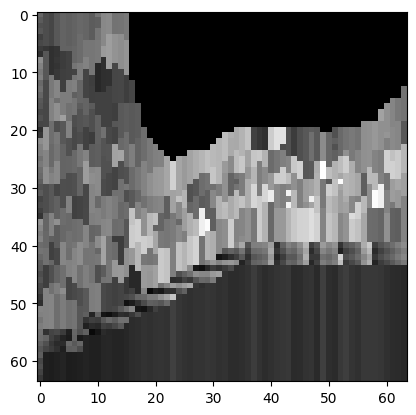

In [145]:
plt.imshow(train_images[0, :, :, 0], cmap="gray")

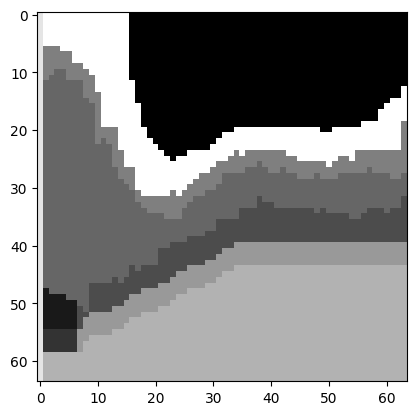

In [146]:
plt.imshow(train_masks[0], cmap="gray")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


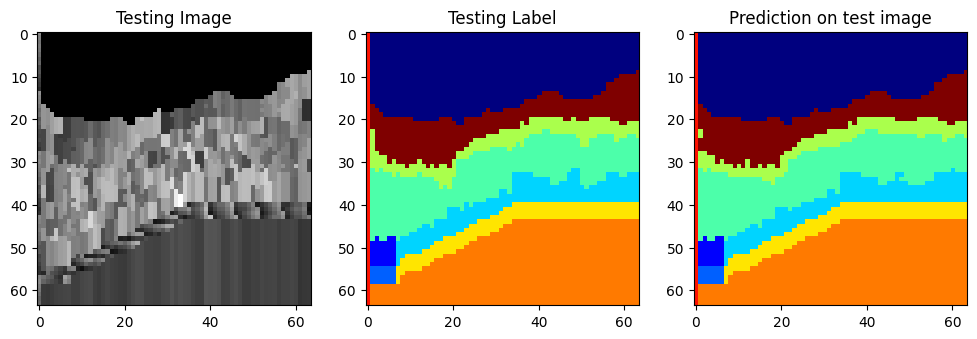

In [147]:
# Predicting the masks on a random test image
import random

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Testing Image")
plt.imshow(test_img[:, :, 0], cmap="gray")
plt.subplot(232)
plt.title("Testing Label")
plt.imshow(ground_truth[:, :, 0], cmap="jet")
plt.subplot(233)
plt.title("Prediction on test image")
plt.imshow(predicted_img, cmap="jet")
plt.show()

In [148]:
# Removing the last layer of the model
pre_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [149]:
# Predicting the features
pre_layer_y_pred = pre_layer_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step


In [150]:
# Reshaping the features for PCA
pre_layer_y_pred = np.array(pre_layer_y_pred)
pre_layer_y_pred = pre_layer_y_pred.reshape(212, -1)
pre_layer_y_pred.shape

(212, 65536)

In [151]:
# Applying PCA
pca = PCA(n_components=200, random_state=22)
pca.fit(pre_layer_y_pred)
pca_data = pca.transform(pre_layer_y_pred)

In [152]:
# Applying KMeans
kmeans = KMeans(n_clusters=5, n_init="auto", random_state=22)
kmeans.fit(pca_data)

KMeans(n_clusters=5, random_state=22)

In [153]:
# Grouping the images based on the clusters
groups = {}
for file, cluster in zip(X_test, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [154]:
# Helper function to view the clusters
def view_cluster(cluster):
    plt.figure(figsize=(25, 25))
    files = groups[cluster]
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    for index, file in enumerate(files):
        plt.subplot(10, 10, index + 1)
        img = file[:, :, 0]
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()

Clipping cluster size from 71 to 30


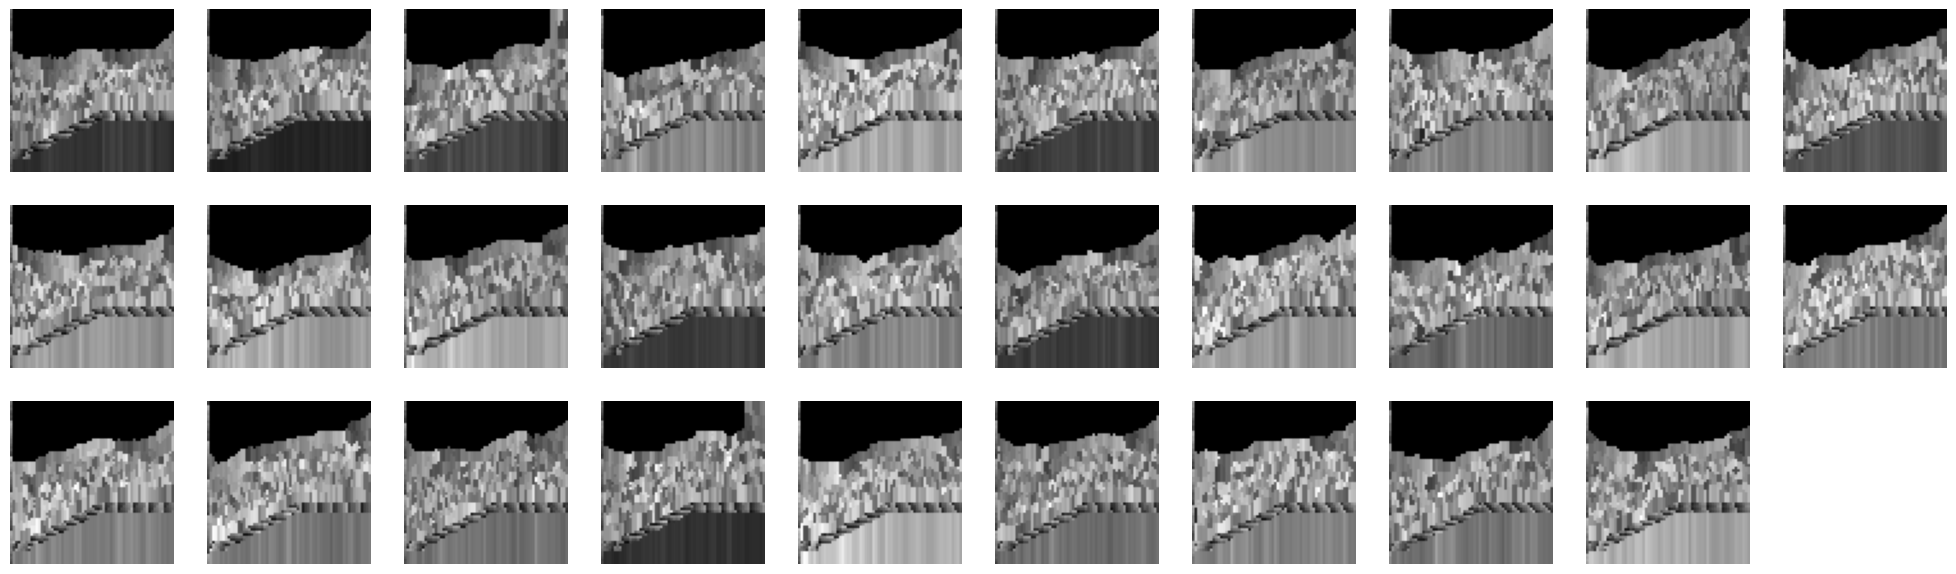

Clipping cluster size from 44 to 30


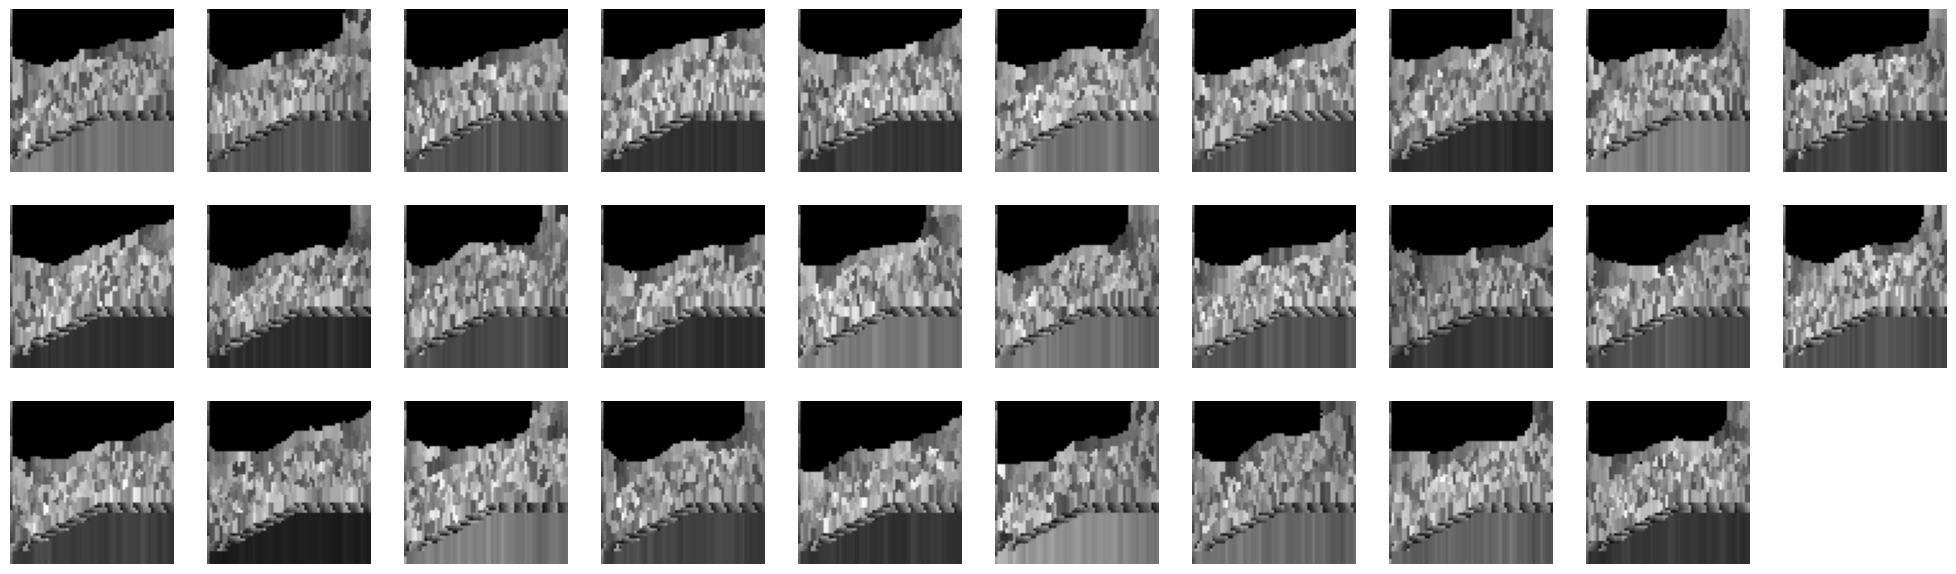

Clipping cluster size from 38 to 30


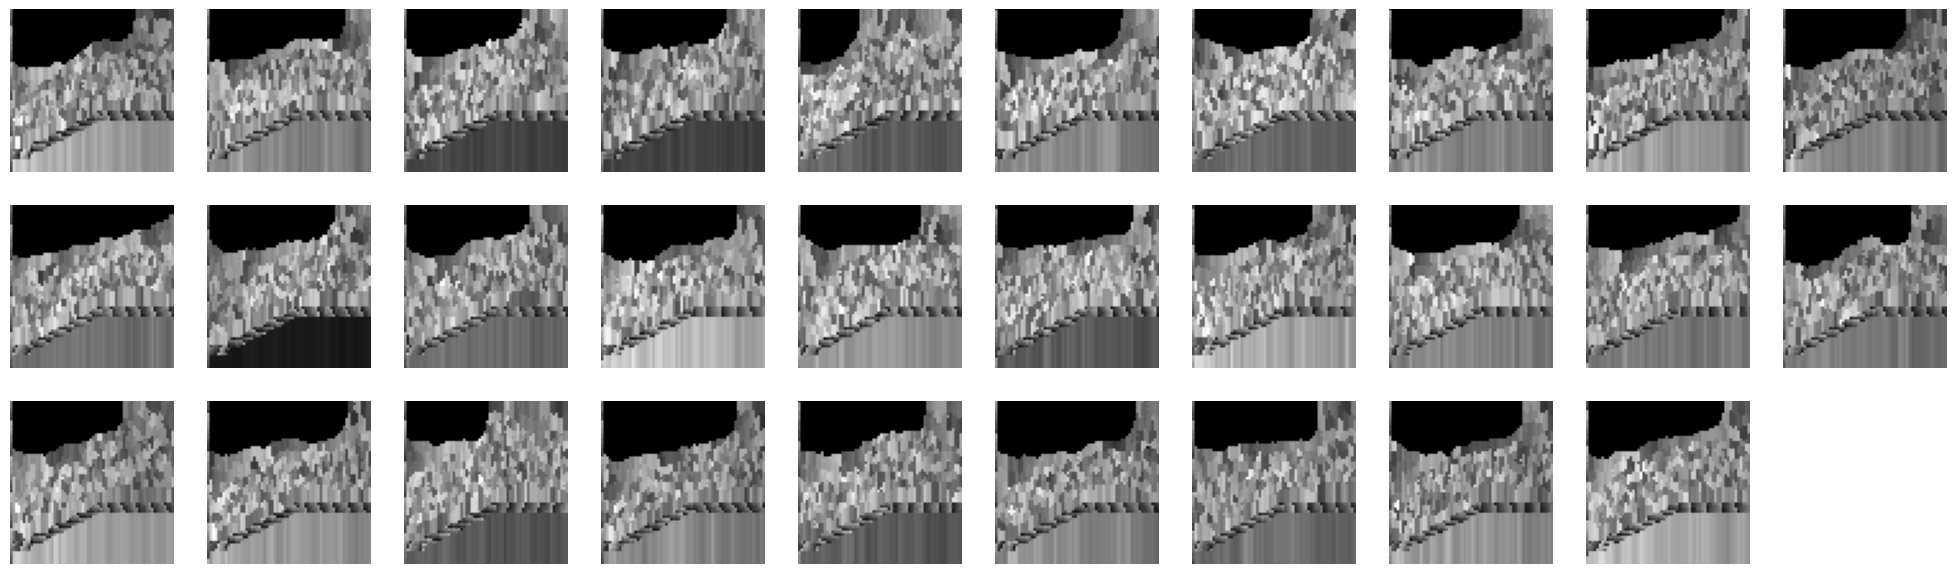

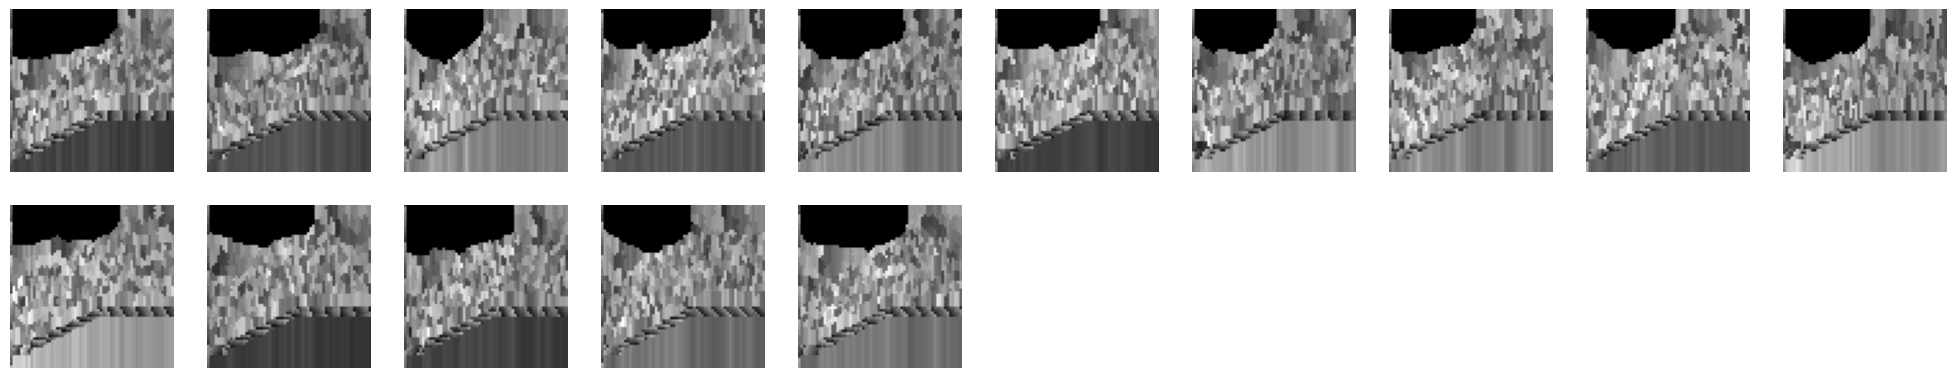

Clipping cluster size from 44 to 30


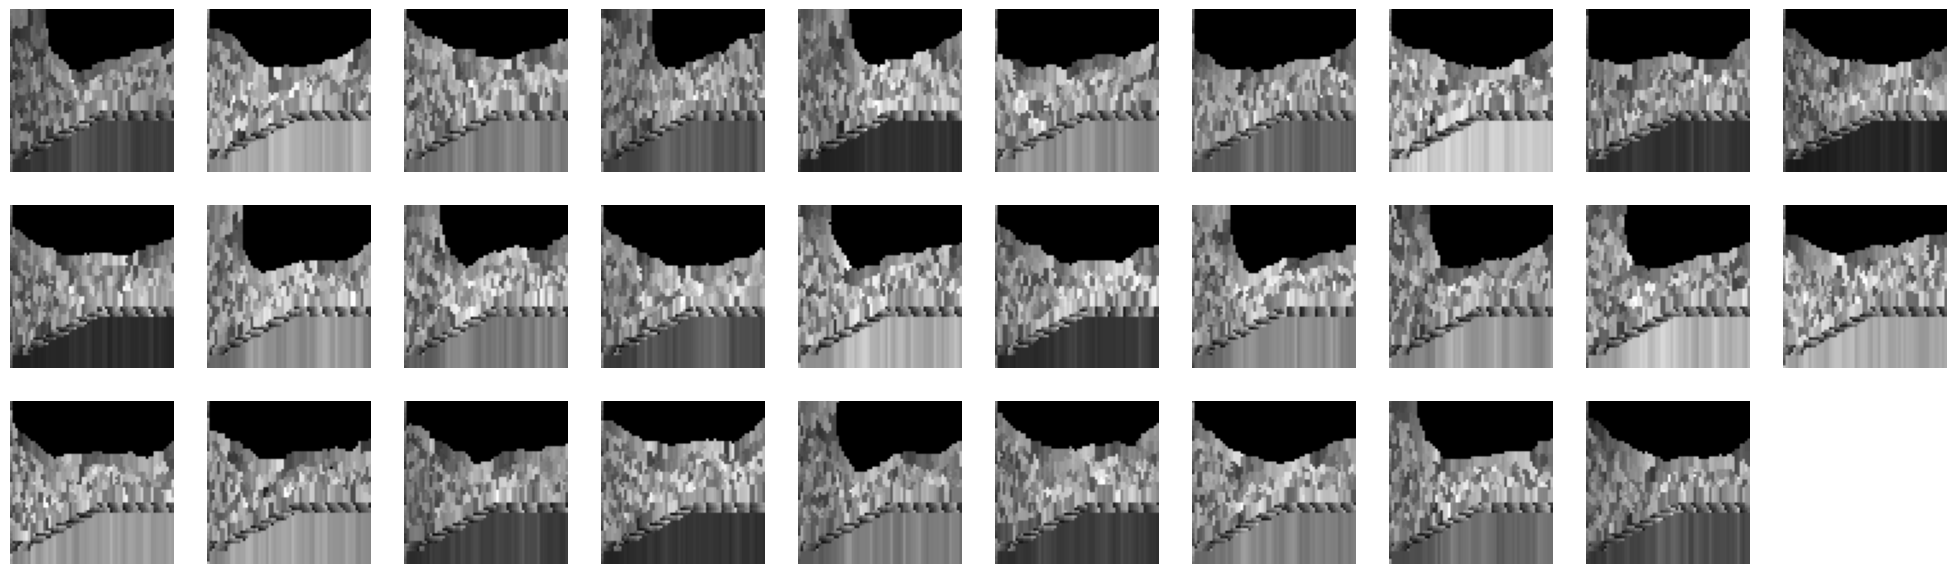

In [155]:
# Viewing the clusters
for key, value in groups.items():
    view_cluster(key)

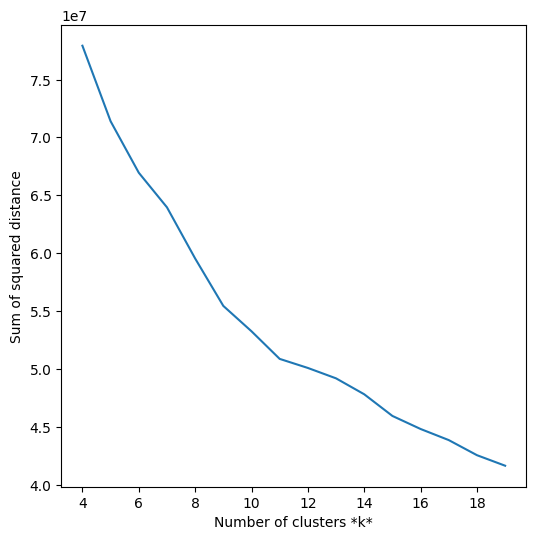

In [156]:
# Calculating the sum of squared distance to find the best number of clusters
sse = []
list_k = list(range(4, 20))

for k in list_k:
    km = KMeans(
        n_clusters=k,
        n_init="auto",
        random_state=22,
    )
    km.fit(pca_data)

    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r"Number of clusters *k*")
plt.ylabel("Sum of squared distance")